In [1]:
!git pull

Already up to date.


In [2]:
import numpy as np
import torch
from environment.Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt
from collections import deque
from tests.test_gw import *
from environment.MarketEnv import MarketEnv
from common.properties import *
from dqn_net import DQNNet

Text(0, 0.5, 'Loss')

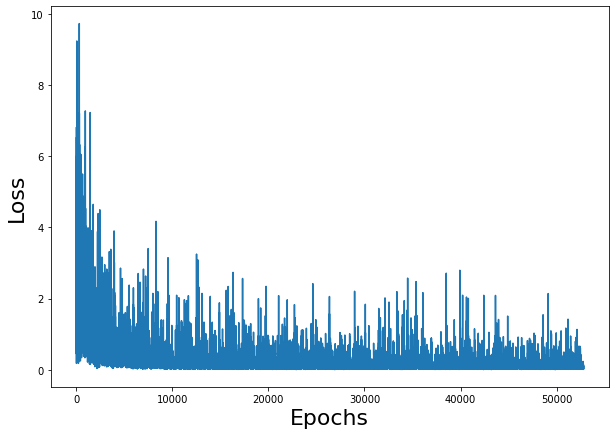

In [3]:


# DQNModel = DQNNet() # Market
STATE_DIM = 64 # GW
DQNModel = DQNNet(state_dim = STATE_DIM, output_size = 4) # GW

model2 = copy.deepcopy(DQNModel.model)
model2.load_state_dict(DQNModel.model.state_dict())

for i in range(epochs):
    # marketEnv = MarketEnv()
    # state1_ = marketEnv.reset()

    game = Gridworld(size=4, mode='random') # GW

    rendered_game_boad_1 = game.board.render_np()
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float().to(device = devid)

    status = 1
    mov = 0

    while(status == 1): 
        j+=1
        mov += 1
        qval = DQNModel(state1)
        
        if not torch.cuda.is_available():
            qval_ = qval.data.numpy()
        else:
            qval_ = qval.data.cpu().numpy()
        
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        # action = action_
        
        # Execute action and upate state, and get reward + boolTerminal
        # marketEnv.step(action)
        # state2_, reward, done, info_dic = marketEnv.step(action)
        
        action = game.action_set[action_]
        game.makeMove(action)
        print(action)
        rendered_game_boad_2 = game.board.render_np()
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float().to(device = devid)
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done)
        replay.append(exp) #H
        state1 = state2
        
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)

            # Could be replaced with pytorch gather
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]).view(batch_size, STATE_DIM).to(device = devid)
            action_batch = torch.tensor([a for (s1,a,r,s2,d) in minibatch]).type(torch.FloatTensor).to(device = devid)
            reward_batch = torch.tensor([r for (s1,a,r,s2,d) in minibatch]).type(torch.FloatTensor).to(device = devid)
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch]).view(batch_size, STATE_DIM).to(device = devid)
            done_batch = torch.tensor([d for (s1,a,r,s2,d) in minibatch]).type(torch.FloatTensor).to(device = devid)

            # Q update
            Q1 = DQNModel(state1_batch).to(device = devid)
            with torch.no_grad():
                Q2 = model2(state2_batch).to(device = devid) #B
            
            Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            
            DQNModel.optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            DQNModel.optimizer.step()
            
            if j % sync_freq == 0: #C
                model2.load_state_dict(DQNModel.model.state_dict())
        if done or mov > max_moves:
            status = 0
            mov = 0
        
losses = np.array(losses)



Text(0, 0.5, 'Loss')

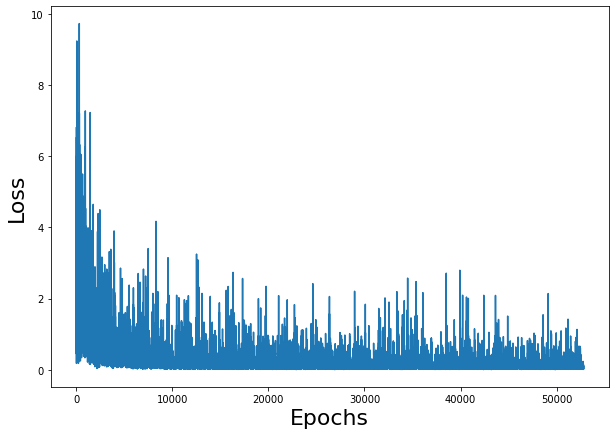

In [4]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)


In [5]:
from tests.test_gw import *

max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(DQNModel.model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 850
Win percentage: 85.0%


In [6]:
state1_ = marketEnv.reset()
state1 = torch.from_numpy(state1_).float().to(device = devid)
state1

NameError: name 'marketEnv' is not defined

In [ ]:
qval = model(state1)
qval

In [ ]:
qval_ = qval.data.cpu().numpy()
action_ = np.argmax(qval_)
action_

In [ ]:
qval_